<a href="https://www.kaggle.com/code/nurulsakinah/titanic-eda?scriptVersionId=194818208" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Introduction
Aim : use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

# 2. Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# ignore warning on infin
import warnings
warnings.simplefilter('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 3. Load the dataset

In [2]:
# read file
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

# 4. Exploratory Data Analysis


In [3]:
print(df.shape)
df.head(10)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
# Check for duplicated values
print(f'Any duplicated values: {df.duplicated().sum()}')

# Check for missing/NaN values
missing_values = df.isnull().sum()
print(f'Missing values: {missing_values}')
print(f'Missing values (%): {round((missing_values / df.shape[0]) * 100, 2)}')

Any duplicated values: 0
Missing values: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Missing values (%): PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64


Features Age, Cabin and Embarked has missing values with Cabin the most. This need to be dealt before building the model.

In [5]:
# Summary of Numeric Features 

def numeric_summary(df):
    obs = df.shape[0]
    
    numeric_df = df.select_dtypes(include='number')
    summary_df = pd.DataFrame({
        'Dtype': numeric_df.dtypes, 
        'Counts': numeric_df.apply(lambda x: x.count()), 
        'Nulls': numeric_df.apply(lambda x: x.isnull().sum()), 
        'NullPercent': (numeric_df.isnull().sum() / obs) * 100,
        'Mean' : numeric_df.mean(),
        'Min': numeric_df.min(),
        'Max': numeric_df.max(),
        'Uniques': numeric_df.apply(lambda x: x.unique().shape[0]),
        'UniqueValues': numeric_df.apply(lambda x: list(x.unique()) if x.nunique() <= 10 else '-')
    })
    
    return summary_df


numeric_summary(df)

,Dtype,Counts,Nulls,NullPercent,Mean,Min,Max,Uniques,UniqueValues
PassengerId,int64,891,0,0.00000,446.000000,1.00,891.0000,891,-
Survived,int64,891,0,0.00000,0.383838,0.00,1.0000,2,"[0, 1]"
Pclass,int64,891,0,0.00000,2.308642,1.00,3.0000,3,"[3, 1, 2]"
Age,float64,714,177,19.86532,29.699118,0.42,80.0000,89,-
SibSp,int64,891,0,0.00000,0.523008,0.00,8.0000,7,"[1, 0, 3, 4, 2, 5, 8]"
Parch,int64,891,0,0.00000,0.381594,0.00,6.0000,7,"[0, 1, 2, 5, 3, 4, 6]"
Fare,float64,891,0,0.00000,32.204208,0.00,512.3292,248,-


We can see there's two label for the target with 1 as survived and 0 for died. Based on Survived column, only ~38% people survived the sinking.


### Explore feature relationships

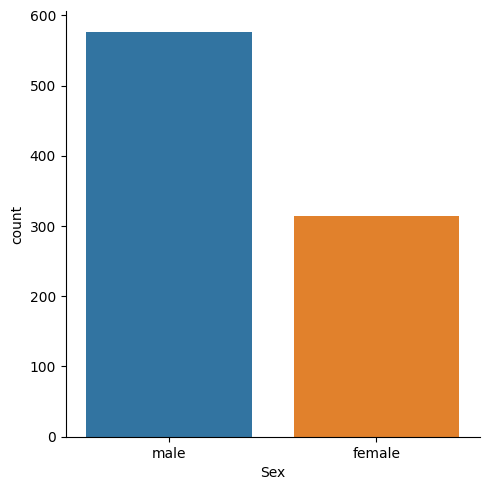

In [6]:
# Create plot to see male and female passengers 
sns.catplot(x='Sex',data=df,kind='count')

Plot shows there were more male passengers than female

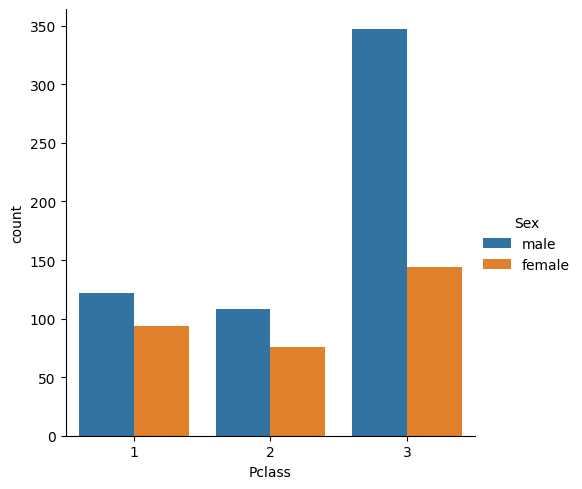

In [7]:
sns.catplot(x='Pclass',data=df,hue='Sex',kind='count')

In all classes, there are more male passengers than female. We would alaso like to see the child distribution in these classes. A new feature 'Person' will be created which consist of female, male and child

In [8]:
# Function to detect if a person is a man, woman or child.
def check_person_age(data):
    age=data['Age']
    sex=data['Sex']
    
    return 'child' if age < 16 else sex

# Apply function method to create new column "Person"
df['Person'] = df.apply(check_person_age,axis=1)

# get overview of the df
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,male
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,child
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,female
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,child


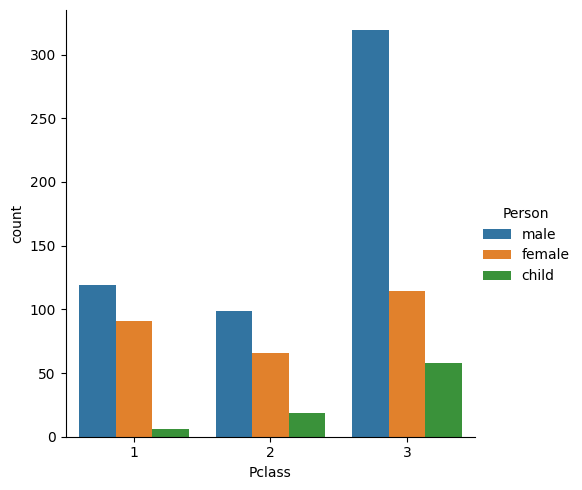

In [9]:
sns.catplot(x='Pclass',data=df,hue='Person',kind='count')

There are more children in the 3rd class and male passengers are the most in all 3 classes.

<Axes: >

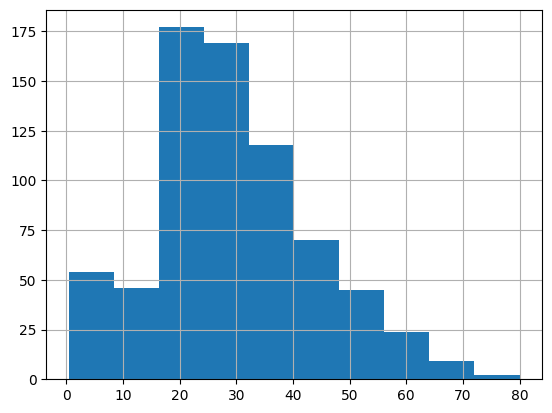

In [10]:
df['Age'].hist()

To see the distribution of passengers of different age groups, create a histogram. Most of the passengers age 20 to 30, with oldest at 80 years old. To get more in-depth analysis on the age feature, check the age distribution for different classes using Seaborn's Facetgrid.

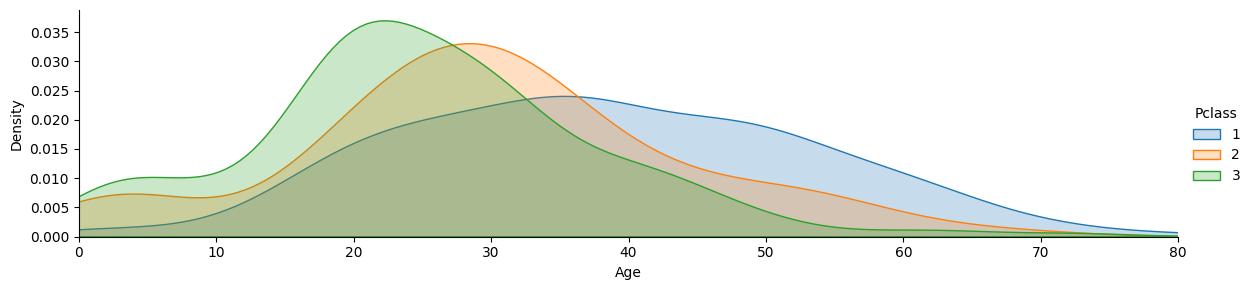

In [11]:
def plot_facetgrid(hue, x_axis):
    '''density plot between 2 features '''
    fig = sns.FacetGrid(df,hue=hue,aspect=4)
    fig.map(sns.kdeplot, x_axis, fill=True)
    oldest = df[x_axis].max()
    fig.set(xlim=(0,oldest))
    fig.add_legend()

    
plot_facetgrid('Pclass', 'Age')

We can clearly see that the first class passengers belonged more to the middle age groups, with very few children.Second and third class had more children, with relatively fewer older people.

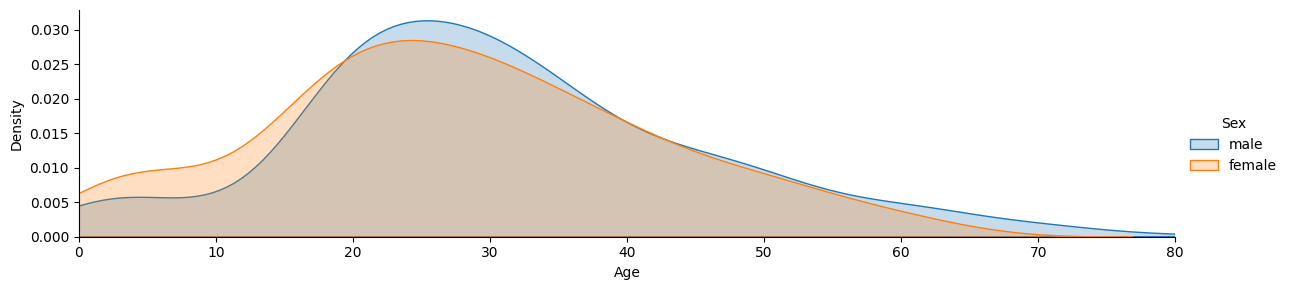

In [12]:
plot_facetgrid('Sex','Age')

There isnt much variation for age between male and female. However we can see that there are more younger female than male

We can explore the pclass and cabin features to see if they can convey any information on the passengers. The cabin feature has highest missing values thus we can for now create another df omitting the missing rows and further explore the feature. From the cabin attribute, we can get the deck the passengers on. For example, a passenger on deck 'C' will have a cabin number in CXXX format, where XXX can be a room number.

In [13]:
# Because the cabin data was missing in a lot of cases, we can just drop it for now for this section.
deck_df = df.dropna(axis=0)

# Get deck from cabin numbers
def get_level(data):
    cabin = data['Cabin']
    # extract the first character which is the deck
    return cabin[0]

# apply the function
deck_df['deck']=deck_df.apply(get_level,axis=1)

deck_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,deck
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female,C
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male,E
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,child,G
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,female,C


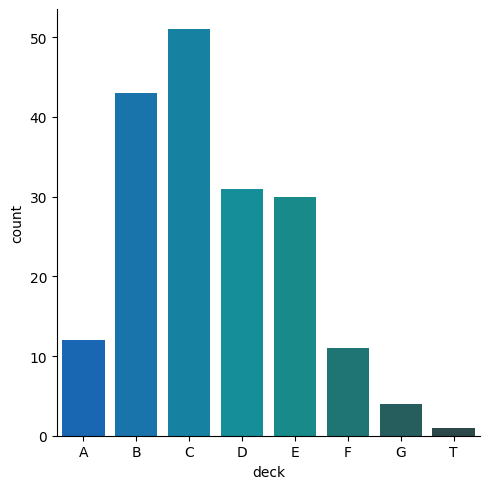

In [14]:
# Sort the DataFrame by 'level' alphabetically
deck_df = deck_df.sort_values(by='deck')

sns.catplot(x='deck',data=deck_df,palette='winter_d',kind='count')

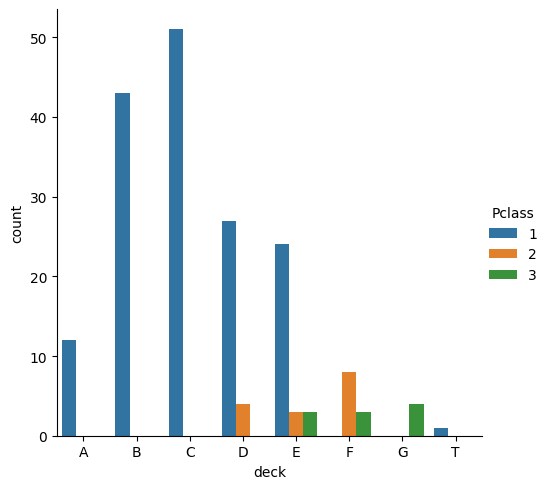

In [15]:
# Create the catplot
sns.catplot(x='deck', data=deck_df, hue='Pclass', kind='count')

Deck A,B,C has only the Pclass 1 and from deck E we can only start seeing Pclass 3. However, we have to keep in mind that cabin information was missing for about 77% of the data

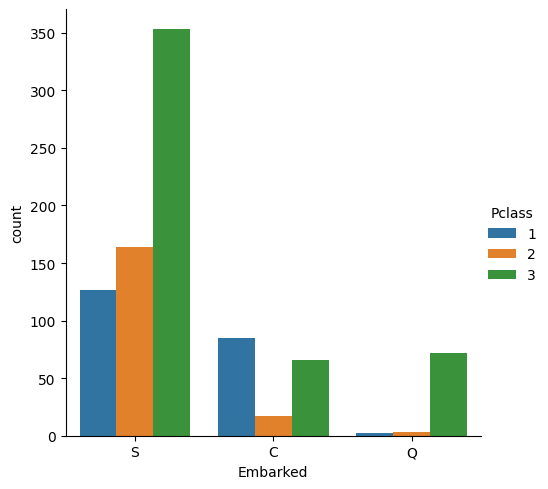

In [16]:
sns.catplot(x='Embarked',data=df,hue='Pclass',kind='count')

The majority of passengers boarded in Southampton. Interestingly, nearly all first and second-class passengers did not board in Queenstown, which may reflect the socio-economic status of Queenstown's population.

### Check if the passengers with family or alone

The SibsSP attribute indicates the number of siblings or spouses a passenger had on board, while Parch represents the number of parents or children they traveled with.

Since we're mainly interested in whether a passenger had any family members on board, we can simplify things by creating a new column to capture this information.

In [17]:
# create another column of 'family_name'
df['family_size']=df['SibSp'] + df['Parch'] + 1


# Initialize the 'Alone' column
df['Alone'] = 'No'

# Update 'Alone' column based on 'family_size'
df.loc[df['family_size'] == 1, 'Alone'] = 'Yes'


df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,family_size,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male,2,No
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female,2,No
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female,1,Yes
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female,2,No
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male,1,Yes


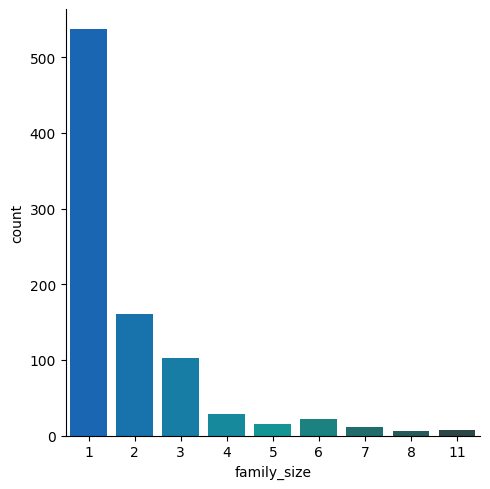

In [18]:
sns.catplot(x='family_size',data=df,palette='winter_d',kind='count')

Seems like most passengers travel alone

### Explore the Relationship Between Features and the Target Variable

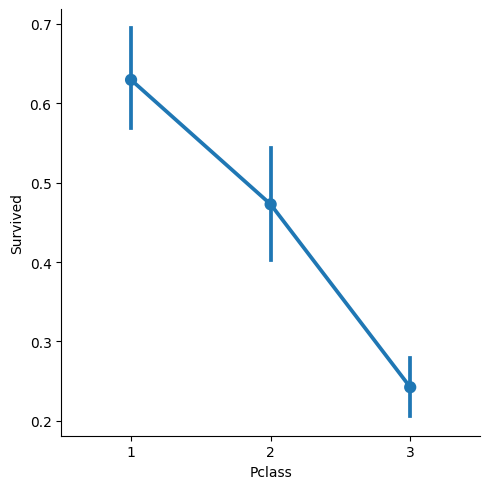

In [19]:
sns.catplot(x='Pclass',y='Survived',data=df,kind='point')

The plot reveals that lower-class passengers had a lower chance of survival. We previously observed that the 3rd class had a higher number of men compared to women and children, more than any other class.

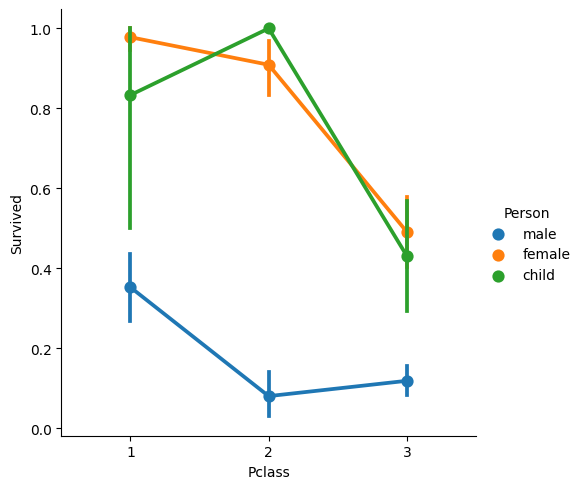

In [20]:
sns.catplot(x='Pclass',y='Survived',hue='Person',data=df, kind='point')

Across all classes, men had lower survival rates than women and children, as they were given less priority during rescue efforts. Overall, men, women, and children in the 3rd class had a significantly lower chance of survival compared to those in the 1st class.


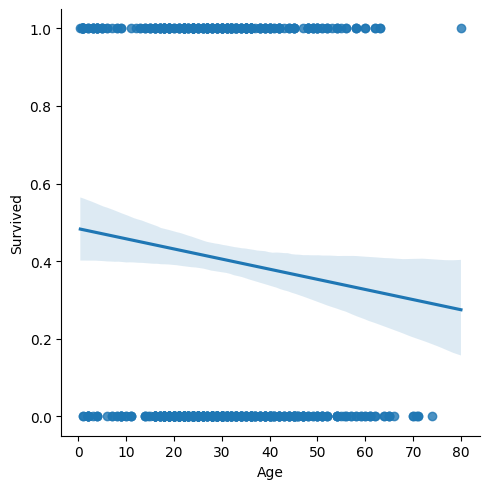

In [21]:
sns.lmplot(x='Age',y='Survived',data=df)

Younger passengers, particularly those aged 0-10, had a higher survival rate. Survival rates decrease with age, especially in the 20-40 age range. 

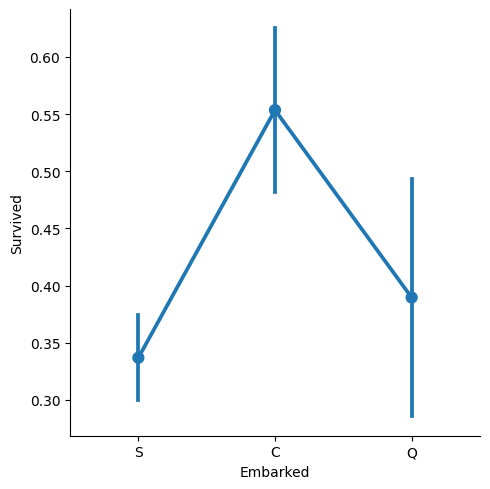

In [22]:
sns.catplot(x='Embarked',y='Survived',data=df,kind='point')

We can see passengers who boarded the ship at Cherbourg had higher rate of surviving.

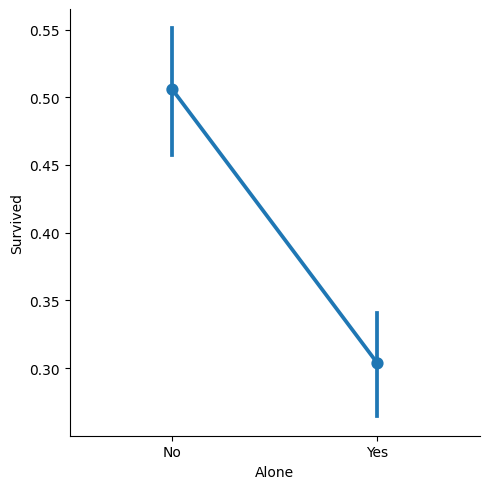

In [23]:
sns.catplot(x='Alone',y='Survived',data=df,kind='point')

Looks like passengers who travel alone had lower chance of survival

### Summary of Insights from Exploratory Data Analysis


First-class passengers, females and child had a higher likelihood of survival. <br>
Passengers who boarded in Cherbourg had better survival rates. <br>
Traveling alone reduced survival chances. <br>
Survival rates decrease with age, especially in the 20-40 age range. <br>


In [24]:


# # Drop unnecessary columns
# # cabin has many missing values so it will be dropped
# columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
# df.drop(columns=columns_to_drop, inplace=True)



## Handling missing data


In [25]:
# drop feature cabin as it contains many nan values
# imputation on missing values on feature Age and Embark
